In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset, which means that it is fairly small by machine learning standards.

Notice that the total_bedrooms attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature.

All attributes are numerical, except for ocean_proximity. Its type is object, so it could hold any kind of Python object. But since you loaded this data from a CSV file, you know that it must be a text attribute.

In [5]:
housing["total_bedrooms"].value_counts()

280.0     55
331.0     51
345.0     50
343.0     49
393.0     49
          ..
1609.0     1
1591.0     1
2506.0     1
2238.0     1
1052.0     1
Name: total_bedrooms, Length: 1923, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


how do you draw a histogram for each column to understand the distribution?

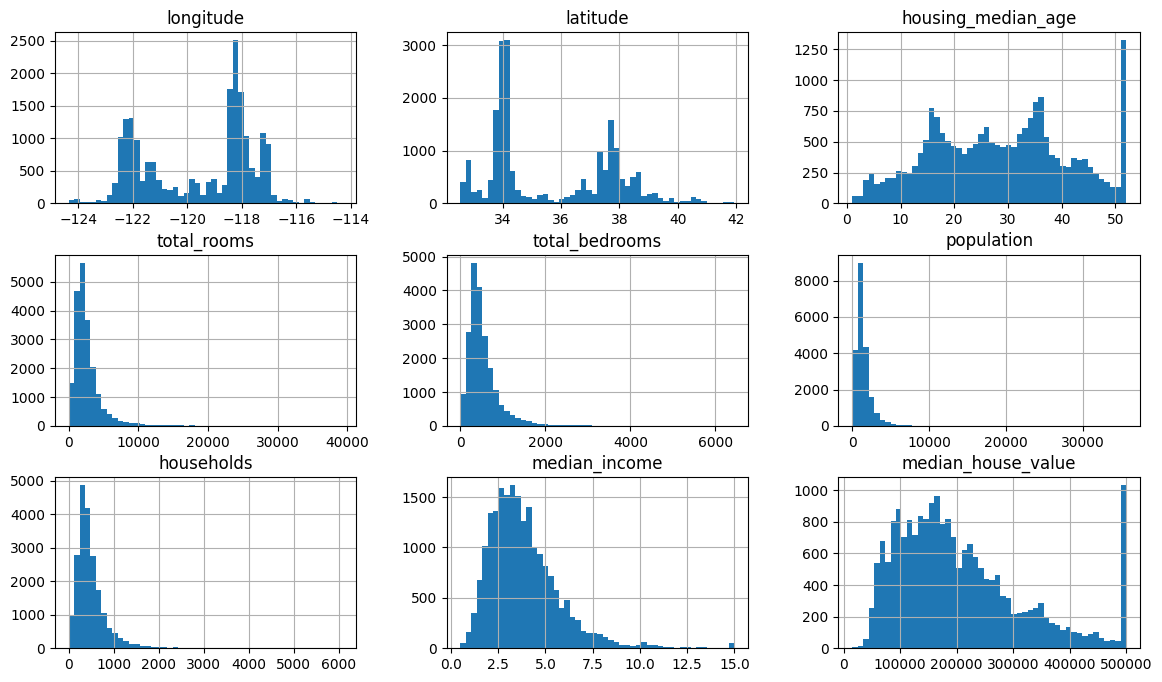

In [7]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(14,8))
plt.show()

**Creating a test set:**
Creating a test set from the dataset is important as we need to evaluate how good our model is performing on data that it hasn't seen before.

**Data Snooping Bias:**
Now, here's where the problem begins. If you keep using the test set over and over to evaluate your robot, tweaking its learning every time it gets something wrong, you're essentially giving it hints about what's on the "final exam." This might make it seem like your robot is getting really good at identifying cats, but actually, it's just getting good at recognizing the cats in the test set.

Data snooping bias occurs when you make decisions about how to improve your model based on the test set. It's like a student who has somehow gotten all the answers to the final exam ahead of time. Sure, they'll score 100%, but it doesn't mean they actually understand the material well.

In [8]:
def create_test_set(dataset, test_ratio):
  #moving 20% of data from dataset to testset
  shuffled_indices = np.random.permutation(len(dataset))
  test_set_size = int(len(dataset)*test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  training_indices = shuffled_indices[test_set_size: ]
  return dataset.iloc[test_indices], dataset.iloc[training_indices]

**stable test/train split:**


In [9]:
import numpy as np
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio): #identifier or row_id
  return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  test_set = ids.apply(lambda id_ : is_id_in_test_set(id_, test_ratio))
  return data.loc[test_set], data.loc[~test_set]


In [10]:
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [11]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Until now we've been sampling randomly. This may introduce **sampling bias**.
Sampling bias happens when the catergory distribution in the sample set is different from the original distribution.
eg: if in a dataset there are 59 females to 41 males. When we sample randomly we might get 20 females and 80 males. Now in the sample set weight is given more to males, which is not the case in the original distribution. **This is sampling bias**.

We avoid sampling bias by maintaining the same distribution of categories in the sample set as the original set.

.

In [12]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])

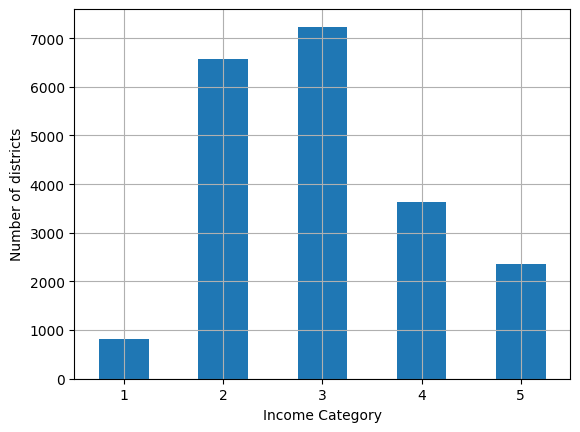

In [16]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()

In [22]:
(housing["income_cat"].value_counts()/len(housing["income_cat"])).sort_index()

1    0.039826
2    0.318847
3    0.350581
4    0.176308
5    0.114438
Name: income_cat, dtype: float64

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [23]:
strat_train_set, strat_test_set = strat_splits[0]

In [25]:
(strat_test_set["income_cat"].value_counts()/len(strat_test_set["income_cat"])).sort_index()

1    0.039971
2    0.318798
3    0.350533
4    0.176357
5    0.114341
Name: income_cat, dtype: float64

Nice, we have the same distribution of categorical feature "income_cat" as the original data.

In [26]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

<ipython-input-26-ba84e3d1e141>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)
<ipython-input-26-ba84e3d1e141>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)
